# **Customer Churn Prediction**
---
*Fábio Chacon (April 2020)*

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ibm_db, ibm_db_dbi
%matplotlib inline

plt.style.use('seaborn-white')

# Imports for tree-based algorithms
import catboost as cb
import xgboost as xgb
import lightgbm as lbg
from sklearn.ensemble import RandomForestClassifier

# Imports for other ML algorithms
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Sklearn Imports for model evalutation
from sklearn.metrics import (plot_precision_recall_curve,
                             roc_auc_score,
                             balanced_accuracy_score,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             f1_score, recall_score, 
                             precision_score)

# For label encoding
from sklearn.preprocessing import LabelEncoder

# Import for spliting the dataset
from sklearn.model_selection import train_test_split

# Imports for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# For scaling the data
from sklearn.preprocessing import StandardScaler

# For feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Connecting to IBM Db2 Database

In [ ]:
dsn_hostname = "---" 
dsn_uid = "---"     
dsn_pwd = "---"      
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"            
dsn_port = "50000"                
dsn_protocol = "TCPIP"            

dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

# About the Dataset


This dataset is about customer churn. Customer churn, also known as costumer attrition, is defined as the loss of custumers or clients by a company. The dataset contains 7043 observations and 21 columns.

&nbsp;



| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| customerID     | ID of a Costumer                                                                      |
| Gender         | The Gender of a costumer                                                              |
| SeniorCitizen  | Whether the customer is a senior citizen or not                                       |
| Partner        | Whether the customer has a partner or not (Yes, No)                                   |
| Dependents       | Whether the customer has dependents or not (Yes, No)                                  |
| tenure           | Number of months the customer has stayed with the company                             |                     
| PhoneService     | Whether the customer has a phone service or not (Yes, No)                             |
| MultipleLines    | Whether the customer has multiple lines or not (Yes, No, No phone service)            |
| InternetService  | Customer’s internet service provider (DSL, Fiber optic, No                            |
| OnlineSecurity   |   Whether the customer has online security or not (Yes, No, No internet service)      |                    | OnlineBackup     |   Whether the customer has online backup or not (Yes, No, No internet service)        |
| DeviceProtection | Whether the customer has device protection or not (Yes, No, No internet service)    |                     | TechSupport      |  Whether the customer has tech support or not (Yes, No, No internet service)                                                          |
| StreamingTV      | Whether the customer has streaming TV or not (Yes, No, No internet service)                                                           |
| StreamingMovies      | Whether the customer has streaming movies or not (Yes, No, No internet service)                                                           |
| Contract      |  The contract term of the customer (Month-to-month, One year, Two year)                                                          |
| PaperlessBilling      |  Whether the customer has paperless billing or not (Yes, No)                                                          |
| PaymentMethod      |  The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))                                                          |
| MonthlyCharges      |  The amount charged to the customer monthly                                                         |
| TotalCharges      |     The total amount charged to the customer                                                       |
| Churn      |           Whether the customer churned or not (Yes or No)                                                 |

# Dataset Overview

## Loading the Data

In [0]:
pconn = ibm_db_dbi.Connection(conn)
data = pd.read_sql("SELECT * FROM TELCO_CUSTOMER_CHURN", pconn)

In [0]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [0]:
data.isnull().sum(axis=1)

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Length: 7043, dtype: int64

In [0]:
data.isnull().sum(axis=0)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

There are 11 missing values in the TotalCharges variable.

In [0]:
# Drops rows with missing values
data.dropna(axis=0, inplace=True)

In [0]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


There are 7043 unique observation. The maximum tenure is 72 months.

&nbsp;

In [0]:
# Drops "customerID" column.
data.drop("customerID", axis=1, inplace=True)

In [0]:
# Replacing numerical encoding in SeniorCitizen variable
data['SeniorCitizen'] = data[['SeniorCitizen']].replace({0: "No", 1: "Yes"})

In [0]:
# Divide tenure into categories
def tenure_to_cat(x):
    if x in range(0, 12):
        return "0-11 months"
    elif x in range(12, 24):
        return "12-23 months"
    elif x in range(24, 36):
        return "24-35 months" 
    elif x in range(36, 48):
        return "36-47 months"
    elif x in range(48, 60):
        return "48-59 months"
    elif x in range(60, 73):
        return "60-72 months"

In [0]:
df = data['tenure'].apply(tenure_to_cat)
data.insert(data.columns.size-1, "tenure_time", df)

# Exploring the Data

## General Information About Customers

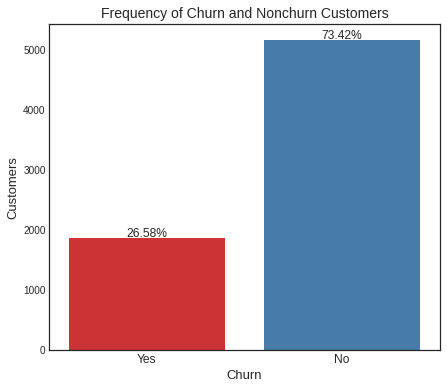

In [11]:
plt.figure(figsize=(7, 6))
churn_count = data["Churn"].value_counts()
g = sns.barplot(x=churn_count.index[::-1], y=churn_count.values[::-1], palette="Set1")
total = churn_count.sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Frequency of Churn and Nonchurn Customers", size=14)
plt.ylabel("Customers", size=13)
plt.xlabel("Churn", size=13)
plt.xticks(fontsize=12)
plt.show()

The above plot clearly shows a class imbalance in the dataset, which means that a machine learning model trained on this dataset, will probably be biased towards the majority class. 

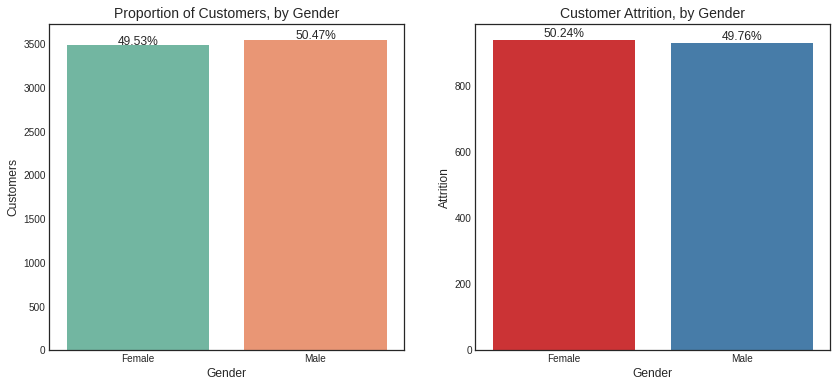

In [12]:
df_gender = data.groupby('gender')['Churn'].value_counts().reset_index(name='Customers')
df_gender_churn = df_gender[df_gender['Churn']=='Yes']

plt.figure(figsize=(14, 6))
plt.subplot(121)
g1 = sns.countplot(x='gender', data=data[['gender']], palette='Set2')
total = data['gender'].value_counts().sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Customers, by Gender", size=14)
plt.ylabel("Customers", size=12)
plt.xlabel("Gender", size=12)

plt.subplot(122)
g2 = sns.barplot(x='gender', y='Customers', data=df_gender_churn, palette="Set1")
total = df_gender_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Customer Attrition, by Gender", size=14)
plt.ylabel("Attrition", size=12)
plt.xlabel("Gender", size=12)
plt.show()

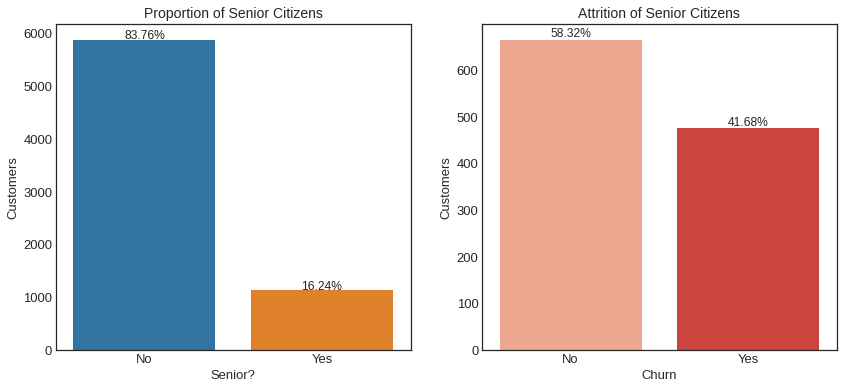

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

df_senior = data.groupby(['SeniorCitizen'])['Churn'].value_counts().reset_index(name='Customers')
senior_count = data[["SeniorCitizen"]]
df_senior_churn = df_senior[df_senior['SeniorCitizen']=='Yes']

g1 = sns.countplot(x='SeniorCitizen', data=senior_count, ax=ax1)
total = senior_count['SeniorCitizen'].value_counts().sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax1.set_ylabel("Customers", size=13)
ax1.set_xlabel("Senior?", size=13)
ax1.tick_params(labelsize=13)
ax1.set_title("Proportion of Senior Citizens", size=14)

g2 = sns.barplot(x='Churn', y='Customers', data=df_senior_churn, palette="Reds", ax=ax2)
total = df_senior_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax2.set_ylabel("Customers", size=13)
ax2.set_xlabel("Churn", size=13)
ax2.tick_params(labelsize=13)
ax2.set_title("Attrition of Senior Citizens", size=14)
plt.show()

Senior citizens comprise roughly 17% of customers (more than 1000 observations). However, there was a high attrition rate of elderly customers. In fact, almost half of them canceled the contract with the company.

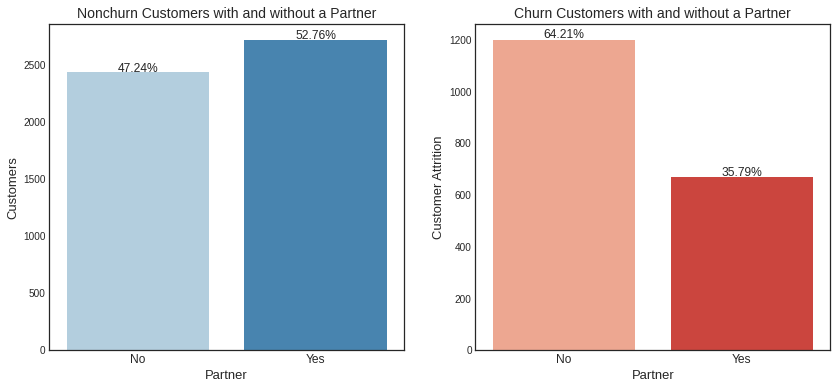

In [0]:
df_partner = data.groupby(['Partner'])['Churn'].value_counts().reset_index(name='Customers')
df_partner_nonchurn = df_partner.query("Churn=='No'")
df_partner_churn = df_partner.query("Churn=='Yes'")

plt.figure(figsize=(14, 6))

plt.subplot(121)
g1 = sns.barplot(x="Partner", y="Customers", data=df_partner_nonchurn, palette="Blues")
total = df_partner_nonchurn.Customers.sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(size=12)
plt.xlabel("Partner", size=13)
plt.ylabel("Customers", size=13)
plt.title("Nonchurn Customers with and without a Partner", size=14)
    
plt.subplot(122)
g2 = sns.barplot(x="Partner", y="Customers", data=df_partner_churn, palette="Reds")
total = df_partner_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(size=12)
plt.xlabel("Partner", size=13)
plt.ylabel("Attrition", size=13)
plt.title('Churn Customers with and without a Partner', size=14)

plt.show()

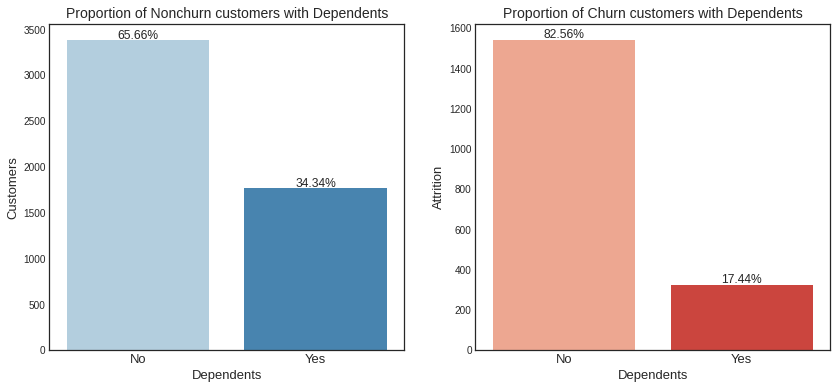

In [0]:
plt.figure(figsize=(14, 6))
df_dependets = data.groupby("Dependents")['Churn'].value_counts().reset_index(name='Customers')
df_dependets_churn = df_dependets.loc[df_dependets['Churn']=='Yes']
df_dependets_nonchurn = df_dependets.loc[df_dependets['Churn']=='No']

plt.subplot(121)
g1 = sns.barplot(x='Dependents', y='Customers', data=df_dependets_nonchurn, palette="Blues")
total = df_dependets_nonchurn.Customers.sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(fontsize=13)
plt.ylabel("Customers", fontsize=13)
plt.xlabel("Dependents", fontsize=13)
plt.title("Proportion of Nonchurn customers with Dependents", size=14)

plt.subplot(122)
g2 = sns.barplot(x='Dependents', y='Customers', data=df_dependets_churn, palette="Reds")
total = df_dependets_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel("Dependents", fontsize=13)
plt.ylabel("Attrition", fontsize=13)
plt.title("Proportion of Churn customers with Dependents", size=14)
plt.show()

# Services Contracted by Customers 

## Internet Sevices

In [0]:
df_tech_info = data.iloc[:, 5:13]
tech_info_cols = df_tech_info.columns
df_tech_info["Churn"] = data[['Churn']]

df_phone_service = df_tech_info[['PhoneService', 'MultipleLines', 'Churn']]
df_net_service = df_tech_info[['InternetService', 'Churn']]

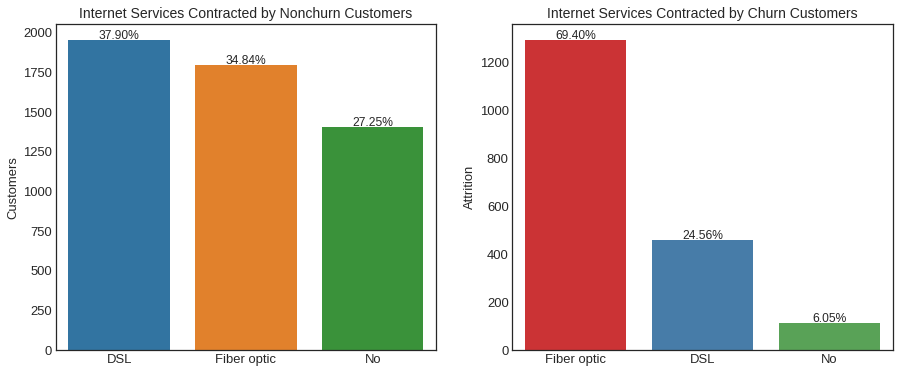

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

df_phone_service = df_tech_info[['PhoneService', 'MultipleLines', 'Churn']]
df_net_service = df_tech_info[['InternetService', 'Churn']]

g1 = sns.countplot(x='InternetService', data=df_net_service.query("Churn=='No'"), ax=ax1)
total = df_net_service.loc[df_net_service['Churn']=='No']["Churn"].value_counts()[0]
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax1.set_title("Internet Services Contracted by Nonchurn Customers", fontsize=14)
ax1.set_xlabel("")
ax1.set_ylabel("Customers", size=13)
ax1.tick_params(labelsize=13)

df_net_service = df_net_service.groupby("InternetService")["Churn"].value_counts()
df_net_churn = df_net_service.loc[:, 'Yes'].reset_index()
df_net_churn = df_net_churn.sort_values(by='Churn', ascending=False)

total = df_net_churn['Churn'].sum()
g2 = sns.barplot(x='InternetService', y='Churn', data=df_net_churn, palette="Set1", ax=ax2)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total * 100),
            ha="center", fontsize=12)
ax2.set_title("Internet Services Contracted by Churn Customers", fontsize=14)
ax2.set_xlabel("")
ax2.set_ylabel("Attrition", size=13)
ax2.tick_params(labelsize=13)
plt.show()

DSL was the choice of the majority of nonchurn customers, while fiber optic, of the churn customers. We must be careful not to be mislead by this information, and immediately infer that the choice of fiber optic as internet service, is correlated with the decision of a customer to leave or switch to another company. The left hand side bar graph shows that 35% of nonchurn customers - which corresponds to more than 1500 observations - also chose fiber optic internet. We must take other variables into account.

## Phone Services

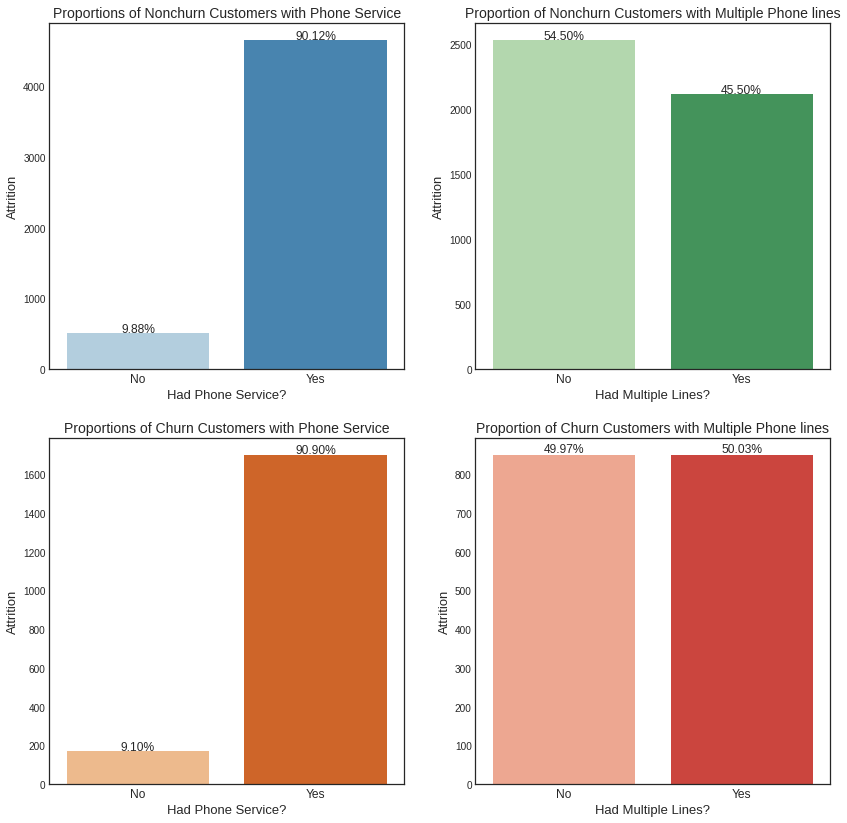

In [0]:
df_phone = df_phone_service.groupby('PhoneService')["Churn"].value_counts().reset_index(name='Customers')
df_phone_churn = df_phone.query("Churn=='Yes'")
df_phone_nonchurn = df_phone.query("Churn=='No'")

plt.figure(figsize=(14, 14))

df_multline = df_phone_service.groupby('MultipleLines')["Churn"].value_counts().reset_index(name='Customers')
df_multline_churn = df_multline.query("(MultipleLines != 'No phone service') & (Churn=='Yes')")
df_multline_nonchurn = df_multline.query("(MultipleLines != 'No phone service') & (Churn=='No')")

plt.subplot(221)
total = df_phone_nonchurn['Customers'].sum()
g1 = sns.barplot(x='PhoneService', y='Customers', data=df_phone_nonchurn, palette='Blues')
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportions of Nonchurn Customers with Phone Service", size=14)
plt.xlabel("Had Phone Service?", size=13)
plt.ylabel("Customers", size=13)
plt.xticks(fontsize=12)

plt.subplot(222)
g2 = sns.barplot(x='MultipleLines', y='Customers', data=df_multline_nonchurn, palette='Greens')
total = df_multline_nonchurn['Customers'].sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Nonchurn Customers with Multiple Phone lines", size=14)
plt.xlabel("Had Multiple Lines?", size=13)
plt.ylabel("Customers", size=13)
plt.xticks(fontsize=12)

plt.subplot(223)
total = df_phone_churn['Customers'].sum()
g1 = sns.barplot(x='PhoneService', y='Customers', data=df_phone_churn, palette='Oranges')
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportions of Churn Customers with Phone Service", size=14)
plt.xlabel("Had Phone Service?", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=12)

plt.subplot(224)
g2 = sns.barplot(x='MultipleLines', y='Customers', data=df_multline_churn, palette='Reds')
total = df_multline_churn['Customers'].sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Churn Customers with Multiple Phone lines", size=14)
plt.xlabel("Had Multiple Lines?", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=12)

plt.show()

## Additional Services

In [0]:
df_tech_info.drop(['InternetService', "PhoneService", 'MultipleLines'], axis=1, inplace=True)
df_tech_info = df_tech_info.where(df_tech_info != 'No internet service')

df_tech_churn = df_tech_info.query("Churn=='Yes'")
df_tech_nonchurn =  df_tech_info.query("Churn=='No'")

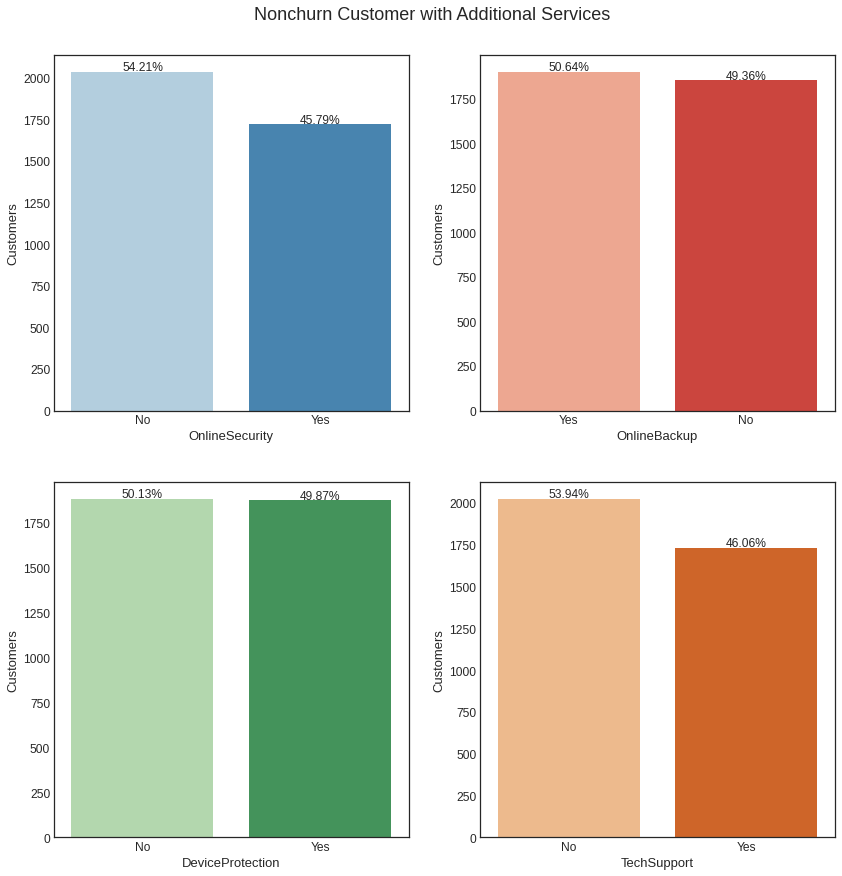

In [0]:
fig, axis = plt.subplots(2, 2, figsize=(14, 13.5))
fig.suptitle('Nonchurn Customer with Additional Services', size=18)
palettes = ["Blues", "Reds", "Greens", "Oranges"]
for ax, col, palette in zip(axis.flatten(), df_tech_nonchurn.columns[:-1], palettes):
    df = df_tech_nonchurn[col].value_counts().reset_index(name='Customers')
    g = sns.barplot(x='index', y='Customers', data=df, palette=palette, ax=ax)
    total = df_tech_nonchurn[col].value_counts().sum()
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
               height+10,
               '{:1.2f}%'.format(height/total*100),
               ha="center", fontsize=12)
        ax.set_ylabel("Customers", size=13)
        ax.set_xlabel(col, size=13)
        ax.tick_params(labelsize=12)

plt.subplots_adjust(top=0.93)
plt.show()

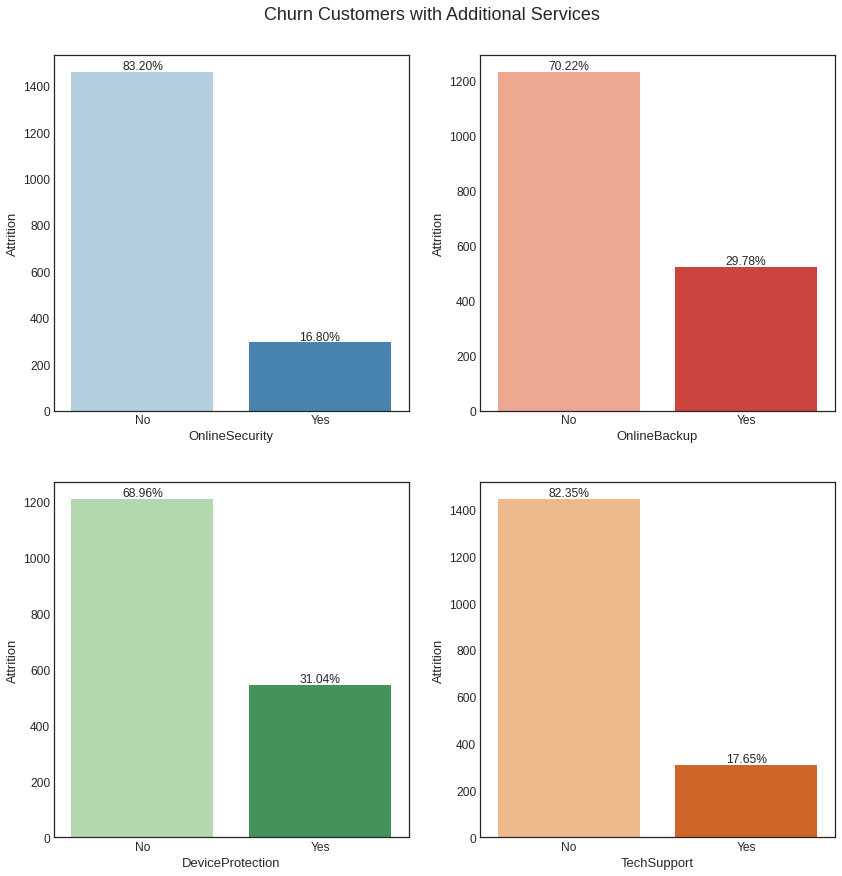

In [0]:
fig, axis = plt.subplots(2, 2, figsize=(14, 13.5))
fig.suptitle('Churn Customers with Additional Services', size=18)
palettes = ["Blues", "Reds", "Greens", "Oranges"]
for ax, col, palette in zip(axis.flatten(), df_tech_churn.columns[:-1], palettes):
    df = df_tech_churn[col].value_counts().reset_index(name='Customers')
    g = sns.barplot(x='index', y='Customers', data=df, palette=palette, ax=ax)
    total = df_tech_churn[col].value_counts().sum()
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
               height+10,
               '{:1.2f}%'.format(height/total*100),
               ha="center", fontsize=12)
        ax.set_ylabel("Attrition", size=13)
        ax.set_xlabel(col, size=13)
        ax.tick_params(labelsize=12)
plt.subplots_adjust(top=0.93)
plt.show()

# Contract type and Payment Method

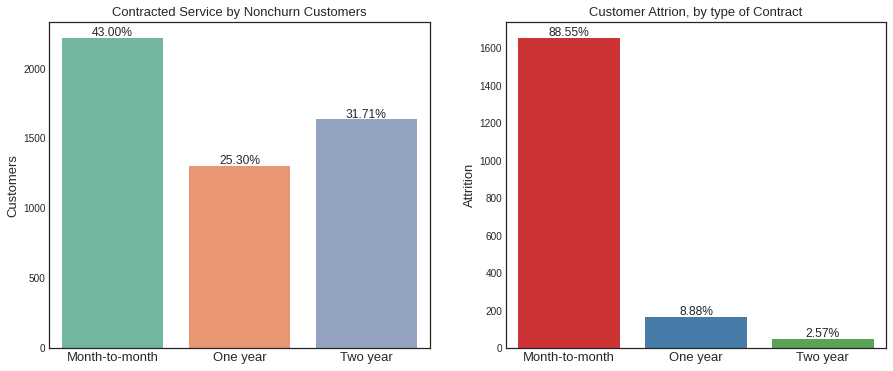

In [0]:
plt.figure(figsize=(15, 6))
df_contract = data.groupby('Contract')['Churn'].value_counts().reset_index(name="Customers")
df_contract_nonchurn = df_contract.loc[df_contract['Churn']=='No']
df_contract_churn = df_contract.loc[df_contract['Churn']=='Yes']

plt.subplot(121)
g = sns.barplot(x='Contract', y='Customers', palette='Set2', data=df_contract_nonchurn)
total = df_contract_nonchurn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total * 100),
         ha="center", fontsize=12)
plt.xlabel(None)
plt.ylabel("Customers", size=13)
plt.xticks(fontsize=13)
plt.title("Contracted Service by Nonchurn Customers", size=13)

plt.subplot(122)
g = sns.barplot(x='Contract', y='Customers', data=df_contract_churn, palette='Set1')
total = df_contract_churn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total * 100),
         ha="center", fontsize=12)   
plt.xlabel(None)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=13)
plt.title("Customer Attrion, by type of Contract", size=13)

plt.show()

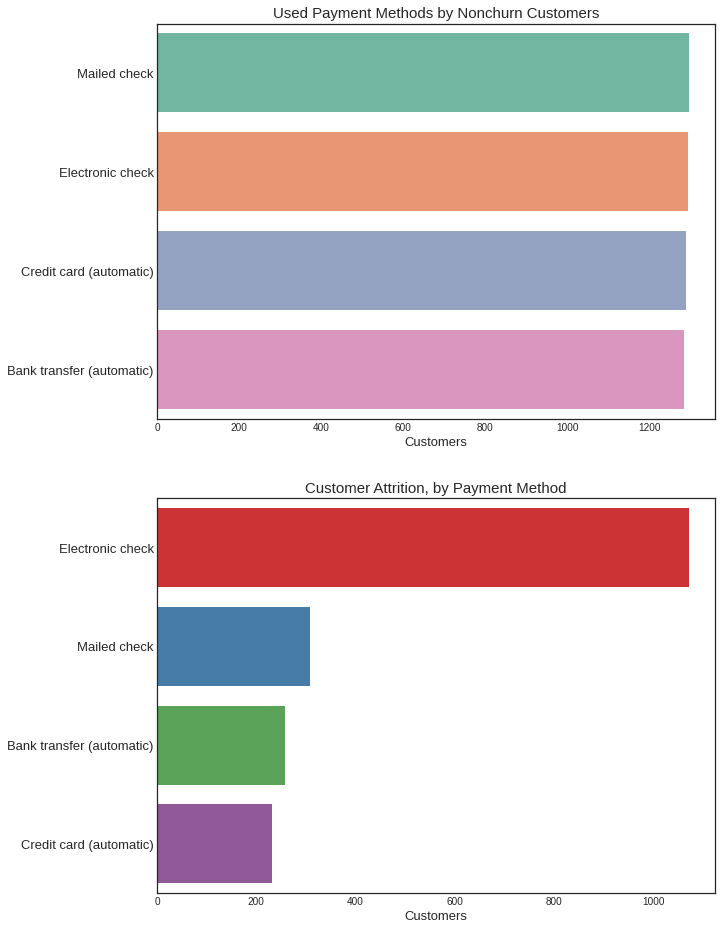

In [0]:
plt.figure(figsize=(10, 16))
df_paymethod = data.groupby("PaymentMethod")['Churn'].value_counts().reset_index(name='Customers')

df_paymethod_nonchurn = df_paymethod.query("Churn=='No'").sort_values(by='Customers', ascending=False)
df_paymethod_churn = df_paymethod.query("Churn=='Yes'").sort_values(by='Customers', ascending=False)

plt.subplot(211)
sns.barplot(x='Customers', y='PaymentMethod', palette='Set2', data=df_paymethod_nonchurn)
plt.ylabel(None)
plt.xlabel("Customers", size=13)
plt.yticks(fontsize=13)
plt.title("Used Payment Methods by Nonchurn Customers", size=15)

plt.subplot(212)
sns.barplot(x='Customers', y="PaymentMethod", palette='Set1', data=df_paymethod_churn)
plt.ylabel(None)
plt.xlabel("Customers", size=13)
plt.yticks(fontsize=13)
plt.title("Customer Attrition, by Payment Method", size=15)
plt.show()

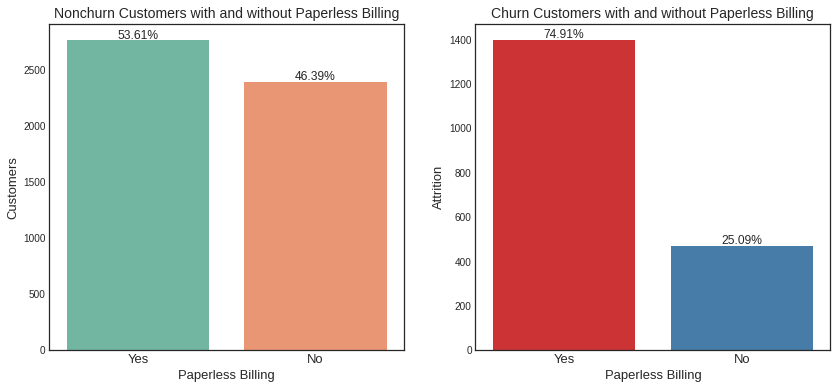

In [0]:
df_contract = data.groupby('PaperlessBilling')["Churn"].value_counts().reset_index(name='Customers')

df_billing_nonchurn = df_contract.query("Churn=='No'").sort_values(by='Customers', ascending=False)
df_billing_churn = df_contract.query("Churn=='Yes'").sort_values(by='Customers', ascending=False)

plt.figure(figsize=(14, 6))
plt.subplot(121)
g = sns.barplot(x='PaperlessBilling', y='Customers', palette='Set2', data=df_billing_nonchurn)
total = df_billing_nonchurn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.ylabel("Customers", size=13)
plt.xlabel("Paperless Billing", size=13)
plt.xticks(fontsize=13)
plt.title("Nonchurn Customers with and without Paperless Billing", size=14)

plt.subplot(122)
g = sns.barplot(x='PaperlessBilling', y='Customers', palette='Set1', data=df_billing_churn)
total = df_billing_churn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.xlabel("Paperless Billing", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=13)
plt.title("Churn Customers with and without Paperless Billing", size=14)
plt.show()

# Tenure of Customers

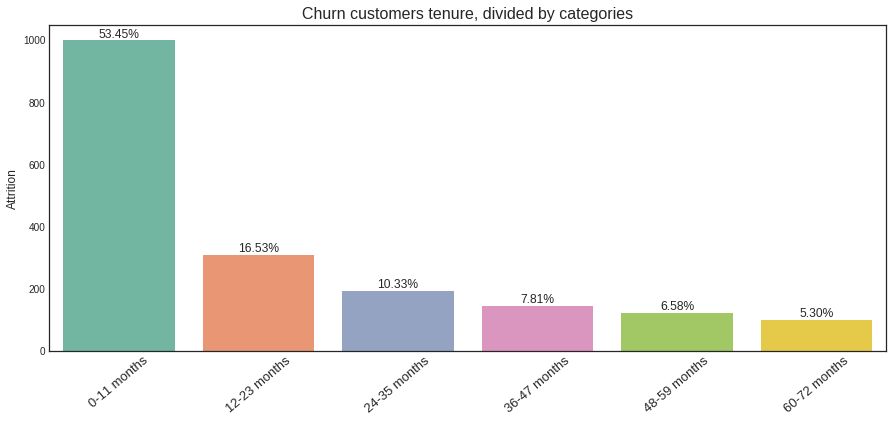

In [0]:
df_tenure = data.groupby('tenure_time')["Churn"].value_counts().reset_index(name="Customers")
df_tenure_churn = df_tenure.query("Churn=='Yes'")
plt.figure(figsize=(15, 6))
g = sns.barplot(x="tenure_time", y='Customers', data=df_tenure_churn, palette="Set2")
total = df_tenure_churn.Customers.sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.xticks(rotation=40, size=13)
plt.ylabel("Attrition", size=12)
plt.title("Churn customers tenure, divided by categories", size=16)
plt.xlabel(None)
plt.show()

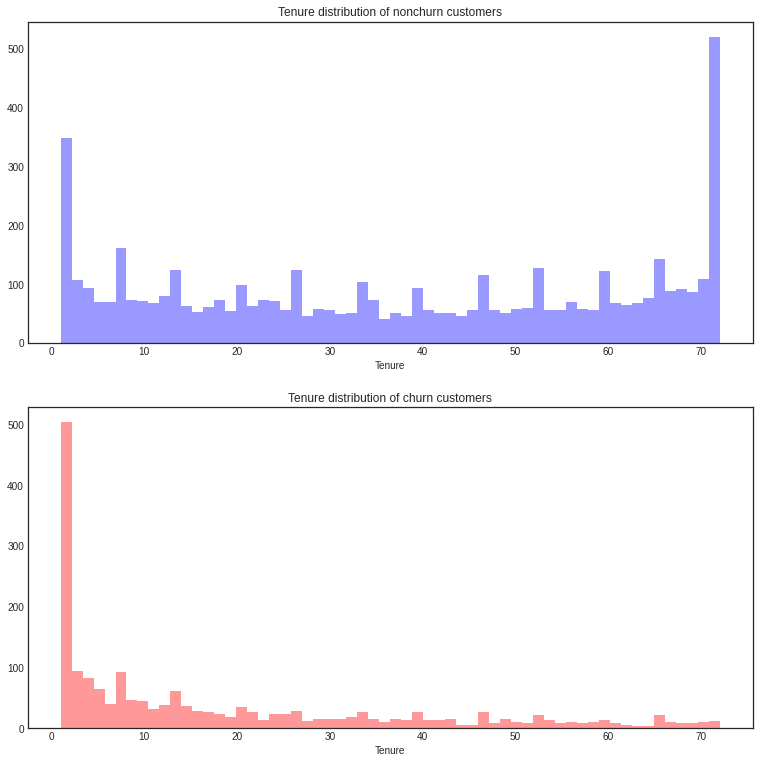

In [0]:
plt.figure(figsize=(13, 13))
plt.subplot(211)
sns.distplot(data.query("Churn=='No'")["tenure"], bins=60, kde=False, color='blue')
plt.title("Tenure distribution of nonchurn customers")
plt.xlabel("Tenure")
plt.subplot(212)
sns.distplot(data.query("Churn=='Yes'")["tenure"], bins=60, kde=False, color='red')
plt.title('Tenure distribution of churn customers')
plt.xlabel("Tenure")
plt.show()

# Monthly Charges Distribution

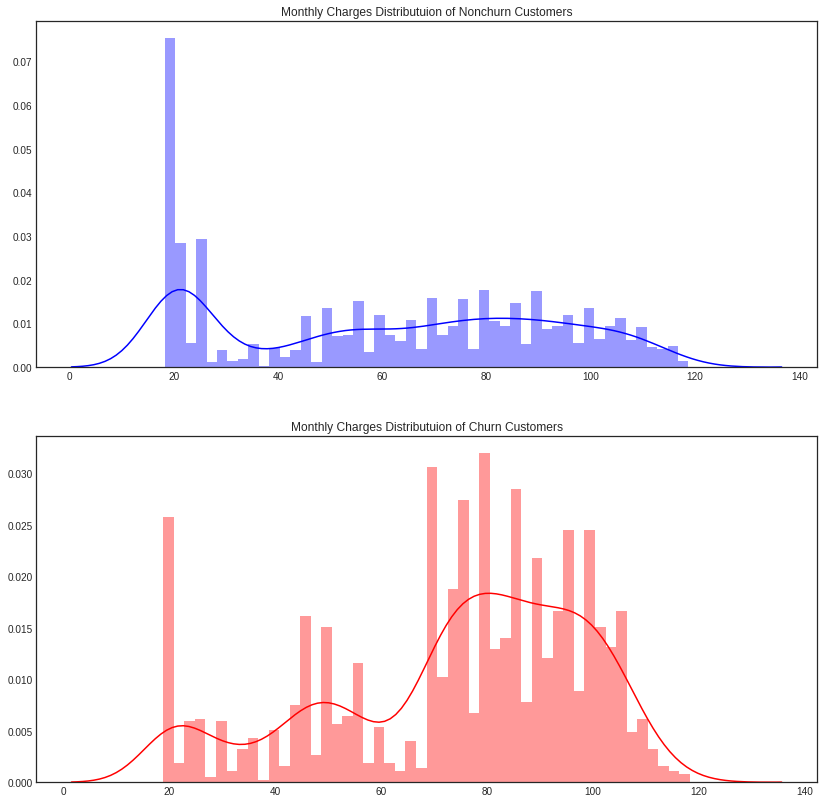

In [0]:
df_charge_nonchurn = data[["MonthlyCharges", 'Churn']].query("Churn=='No'")[['MonthlyCharges']]
df_charge_churn = data[["MonthlyCharges", 'Churn']].query("Churn=='Yes'")[['MonthlyCharges']]

plt.figure(figsize=(14, 14))

plt.subplot(211)
sns.distplot(df_charge_nonchurn , bins=50, kde=True, color='blue')
plt.title("Monthly Charges Distributuion of Nonchurn Customers")

plt.subplot(212)
sns.distplot(df_charge_churn , bins=50, kde=True, color='red')
plt.title("Monthly Charges Distributuion of Churn Customers")

plt.show()

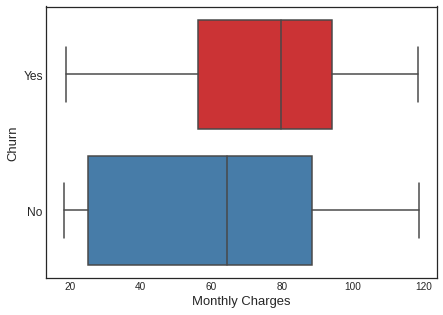

In [0]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='MonthlyCharges', y='Churn', data=data, order=["Yes", "No"], palette="Set1")
plt.xlabel('Monthly Charges', size=13)
plt.ylabel('Churn', size=13)
plt.yticks(size=12)
plt.show()

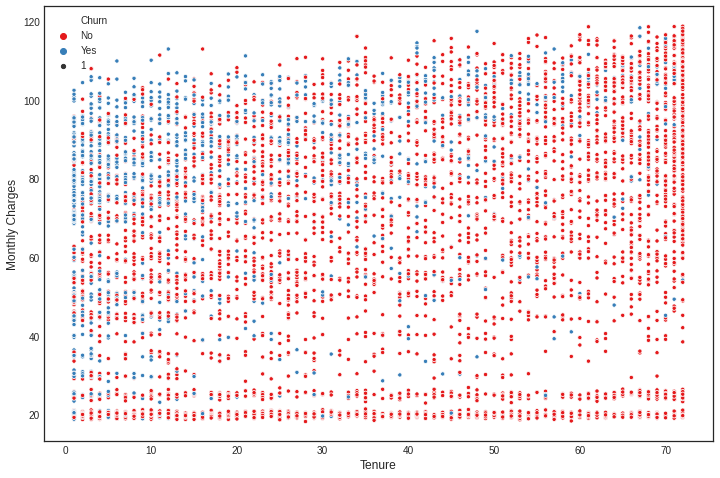

In [0]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tenure', 
                y='MonthlyCharges', 
                hue="Churn", 
                data=data, 
                size=1,
                palette='Set1')
plt.xlabel("Tenure", size=12)
plt.ylabel("Monthly Charges", size=12)
plt.show()    

# Data Pre-processig

## Enconding class labels

In [0]:
lab_encoder = LabelEncoder()
Class_labels = data[['Churn']]
Class_labels = Class_labels.apply(lab_encoder.fit_transform)

## One-hot encoding categorical features

In [177]:
multiclass_col = data.nunique().drop(["Churn"])[data.nunique() <= 6].index
Feature_multiclass = data[multiclass_col]
Feature_multiclass = pd.get_dummies(Feature_multiclass)
Feature_multiclass.head()

,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_time_0-11 months,tenure_time_12-23 months,tenure_time_24-35 months,tenure_time_36-47 months,tenure_time_48-59 months,tenure_time_60-72 months
0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
2,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0
3,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
4,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0


## Creating DataFrame for numerical features

In [178]:
numeric_col = data.nunique()[data.nunique() > 6].index
Feature_numeric = data[numeric_col]
Feature_numeric.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,"1,889.50"
2,2,53.85,108.15
3,45,42.30,"1,840.75"
4,2,70.70,151.65


## Concatenating DataFrames

In [179]:
df_feature = pd.concat([Feature_numeric, Feature_multiclass, Class_labels], axis=1)
df_feature.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_time_0-11 months,tenure_time_12-23 months,tenure_time_24-35 months,tenure_time_36-47 months,tenure_time_48-59 months,tenure_time_60-72 months,Churn
0,1,29.85,29.85,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
1,34,56.95,"1,889.50",0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,2,53.85,108.15,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1
3,45,42.30,"1,840.75",0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1


## Loading the data as numpy arrays

In [0]:
X_data, y_true = df_feature.iloc[:, :-1].values, df_feature['Churn'].values.astype(int)

# Model Fitting

In [181]:
# Splitting the data into a training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_true, test_size=.3, 
                                                    random_state=111, stratify=y_true)

# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("Train size: {} | Test size: {}".format(X_train.shape[0], X_test.shape[0]))

Train size: 4922 | Test size: 2110


In [0]:
def val_kfold(model):
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(model, 
                             X_train, y_train, 
                             scoring='recall', 
                             cv=kfold)
    return scores

def plot_feature_importances(model):
    """
    This function shows feature importances
    for tree-based models.
    """
    plt.figure(figsize=(14, 3.5))
    ft_labels = df_feature.columns[:-1]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    sns.barplot(x=ft_labels[indices], y=importances[indices], palette="Blues")
    plt.title("Feature Importances ({})".format(type(model).__name__), size=12)
    plt.xlim([X_train.shape[1], -1])
    plt.xticks(rotation=90)
    plt.show()

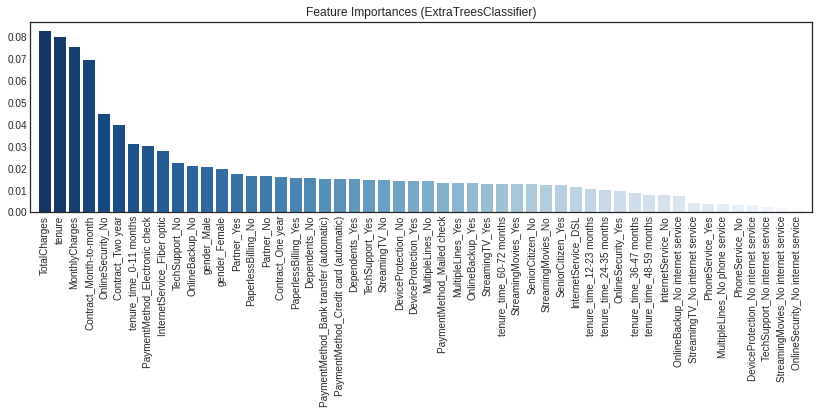

In [183]:
# Feature selection Procedure
clf = ExtraTreesClassifier(n_estimators=50,
                           class_weight='balanced')
clf.fit(X_train, y_train)
plot_feature_importances(clf)
model = SelectFromModel(clf, prefit=True)
X_train, X_test = model.transform(X_train), model.transform(X_test)

## Tree-based Models

### Random Forest

In [184]:
RF_clf = RandomForestClassifier(
    criterion='gini',
    class_weight='balanced',
    n_estimators=100,
    max_depth=7
)

scores = val_kfold(RF_clf)
print("CV Recall: %.2f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV Recall: 0.76 +/- 0.037


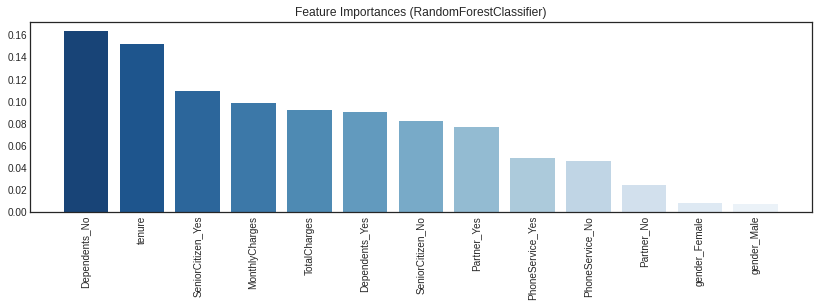

In [185]:
RF_clf.fit(X_train, y_train)
plot_feature_importances(RF_clf)

### XGBoost

In [186]:
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    booster='gbtree',
    max_depth=2,
    scale_pos_weight=2,
    colsample_bytree=.4,
    colsample_bylevel=.2,
    n_jobs=-1,
    min_child_weight=15,
    n_estimators=100,
    num_round=200
)
scores = val_kfold(xgb_clf)
print("CV Recall: %.2f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV Recall: 0.72 +/- 0.033


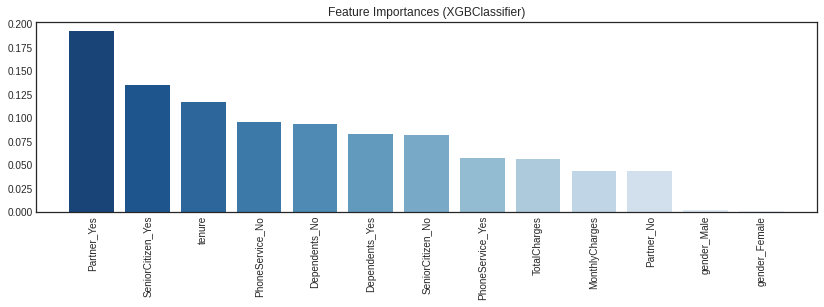

In [187]:
xgb_clf.fit(X_train, y_train)
plot_feature_importances(xgb_clf)

### LightGBM

In [188]:
lgb_clf = lbg.LGBMClassifier(
    max_depth=3,
    min_data_in_leaf=15,
    min_child_samples=30,
    scale_pos_weight=2,
    num_leaves=50,
    n_estimators=100
  )

scores = val_kfold(lgb_clf)
print("CV Recall: %.2f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV Recall: 0.71 +/- 0.036


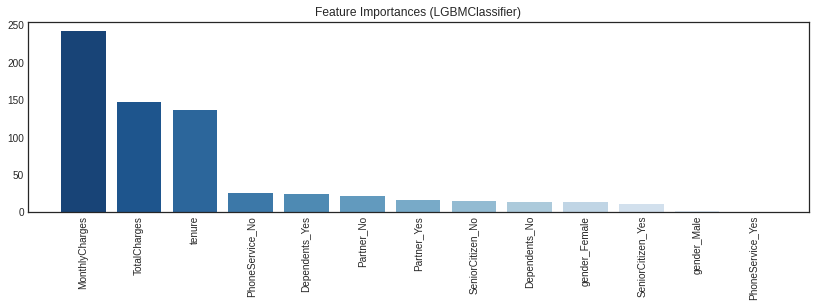

In [189]:
lgb_clf.fit(X_train, y_train)
plot_feature_importances(lgb_clf)

### Catboost

In [190]:
cb_clf = cb.CatBoostClassifier(
    random_seed=63,
    depth=3,
    iterations=100,
    learning_rate=0.01,
    l2_leaf_reg=3,
    bagging_temperature=1,
    class_weights=[1, 2],
    verbose=0,
    random_strength=1,
    one_hot_max_size=2
)

scores = val_with_kfold(cb_clf)
print("CV Recall: %.2f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV Recall: 0.76 +/- 0.039


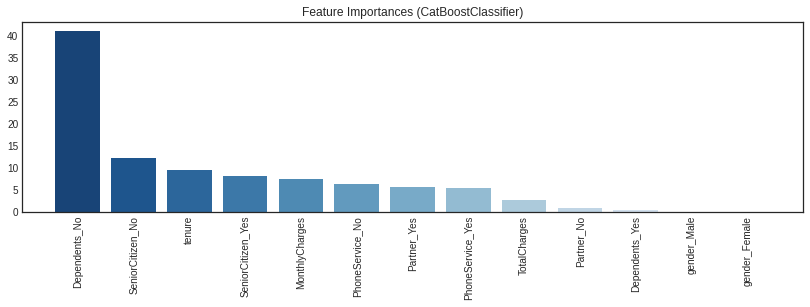

In [191]:
cb_clf.fit(X_train, y_train)
plot_feature_importances(cb_clf)

## Testing other classification algorithms

### KNeighbors

In [192]:
# Finding the best K
Ks = 60
rec = []
for k in range(1, Ks):
    knn = kNN(n_neighbors=k, metric='minkowski')
    knn.fit(X_train, y_train)
    knn_yhat = knn.predict(X_test)
    rec.append((k, recall_score(y_test, knn_yhat)))
best_k = sorted(rec, key=lambda x:x[1], reverse=True)[0][0]
print("Best K is", best_k)

Best K is 19


In [193]:
# Train with the best K
knn = kNN(n_neighbors=best_k, p=2, leaf_size=50, metric='minkowski')
scores = val_kfold(knn)
print("CV Recall: %.2f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV Recall: 0.55 +/- 0.050


In [194]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=50, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

### SVM

In [195]:
svm = SVC(kernel='rbf', C=0.01, 
          class_weight='balanced', random_state=1)
scores = val_kfold(svm)
print("CV Recall: %.2f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV Recall: 0.79 +/- 0.028


In [196]:
svm.fit(X_train, y_train)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=1,
    shrinking=True, tol=0.001, verbose=False)

### Logistic Regression

In [197]:
lr = LogisticRegression(penalty='l2', C=0.01,
                        class_weight='balanced',
                        random_state=1)
scores = val_kfold(lr)
print("CV Recall: %.2f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV Recall: 0.79 +/- 0.027


In [198]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Naive Bayes

In [199]:
bnb_clf = BernoulliNB()
scores = val_kfold(bnb_clf)
print("CV Recall: %.2f +/- %.3f" % (np.mean(scores), np.std(scores)))
bnb_clf.fit(X_train, y_train)

CV Recall: 0.74 +/- 0.033


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

# Model Evaluation and Results

In [200]:
models = [xgb_clf, lgb_clf, cb_clf, RF_clf, knn, svm, lr, bnb_clf]
f1score = [f1_score(y_test, model.predict(X_test)) for model in models]
rec = [recall_score(y_test, model.predict(X_test)) for model in models]
pre = [precision_score(y_test, model.predict(X_test)) for model in models]
bal_acc = [balanced_accuracy_score(y_test, model.predict(X_test)) for model in models]
roc_auc = [roc_auc_score(y_test, model.predict(X_test)) for model in models]

df_results = pd.DataFrame({"Algorithm" : [type(model).__name__ for model in models],
                           "Balanced Acc" : bal_acc,
                           "Recall" : rec,
                           "Precision" : pre,
                           "F1-Score" : f1score,
                           "ROC AUC" : roc_auc})
pd.options.display.float_format = '{:,.2f}'.format
df_results

,Algorithm,Balanced Acc,Recall,Precision,F1-Score,ROC AUC
0,XGBClassifier,0.76,0.73,0.57,0.64,0.76
1,LGBMClassifier,0.76,0.72,0.57,0.63,0.76
2,CatBoostClassifier,0.76,0.75,0.55,0.64,0.76
3,RandomForestClassifier,0.77,0.77,0.55,0.64,0.77
4,KNeighborsClassifier,0.72,0.56,0.61,0.58,0.72
5,SVC,0.76,0.80,0.52,0.63,0.76
6,LogisticRegression,0.77,0.80,0.52,0.63,0.77
7,BernoulliNB,0.75,0.74,0.53,0.62,0.75


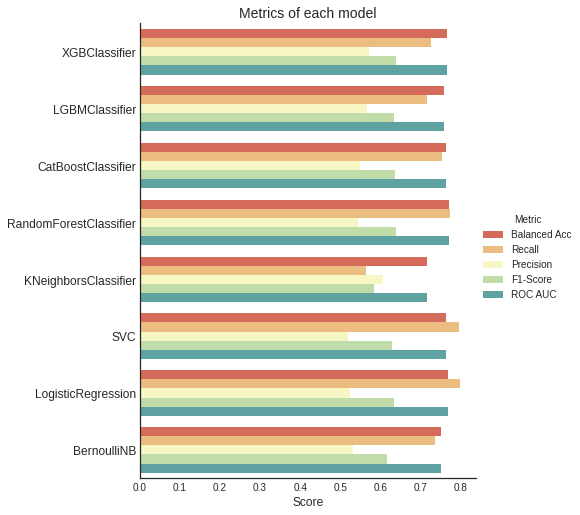

In [202]:
df_scores = df_results.set_index('Algorithm').stack()\
                      .rename_axis(['Algorithm', 'Metric'])\
                      .reset_index(name='Score')
                                 
sns.catplot(x="Score", 
            y='Algorithm',
            hue='Metric', 
            data=df_scores,
            height=7,
            kind='bar',
            palette="Spectral")
plt.ylabel(None)
plt.xlabel("Score", size=12)
plt.yticks(size=12)
plt.title("Metrics of each model", size=14)
plt.show()

Because we trained and evaluated our models using an imbalanced dataset, standard predictive accuracy is not an appropriate metric to assess the quality of our models. Here we used *balanced accuracy*, a measure of accuracy for the imbalanced class scenario, defined as the average of recall obtained on each class. But we are more interested in predict whether a particular customer will churn. For this purpuse, recall is a reasonable metric, because it is a measure of the true positive rate: the proportion of samples the algorithm correctly classified as being of the positive class.

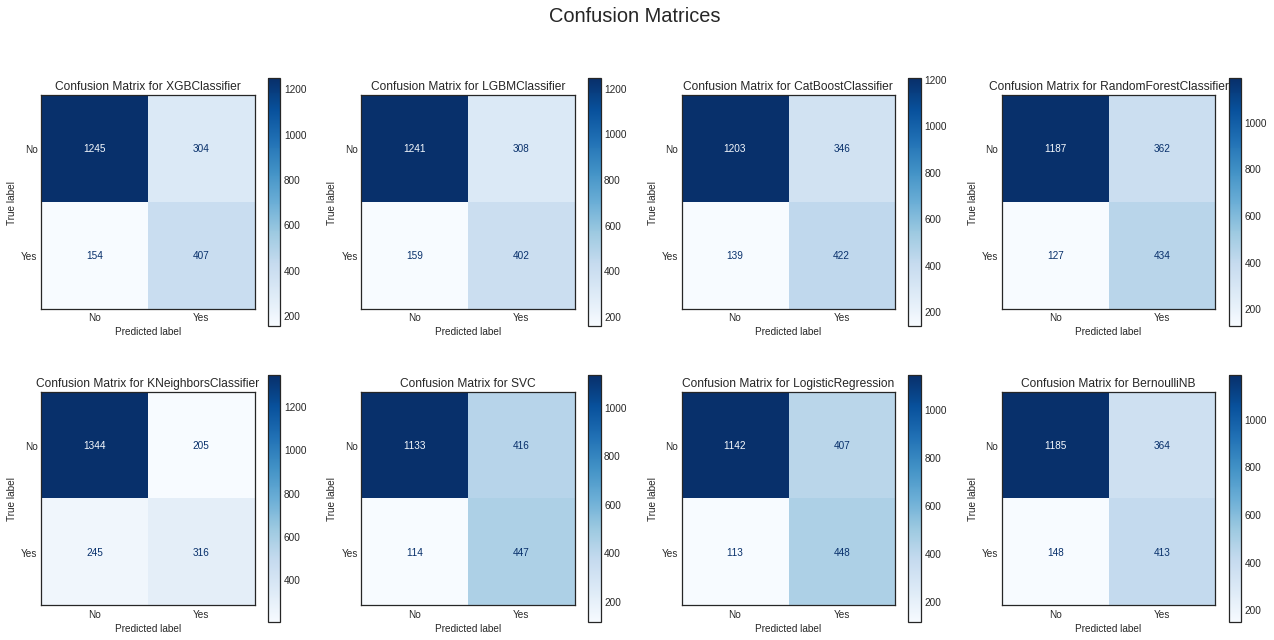

In [203]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle("Confusion Matrices", size=20)
for model, axes in zip(models, ax.flatten()):
    cm = plot_confusion_matrix(model, X_test, y_test,
                               display_labels=['No', 'Yes'],
                               cmap="Blues",
                               normalize=None,
                               values_format='.10g',
                               ax=axes)
    cm.ax_.set_title("Confusion Matrix for {}".format(type(model).__name__))
plt.show()

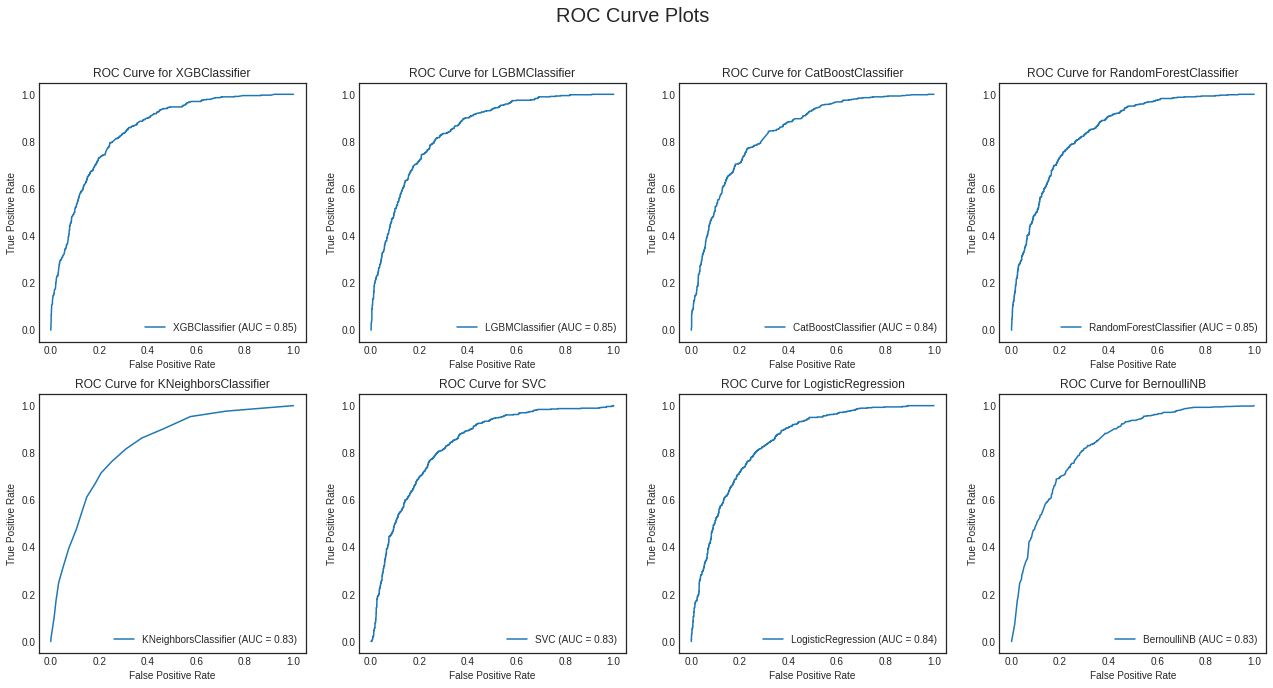

In [204]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10.5))
fig.suptitle("ROC Curve Plots", size=20)
for model, axes in zip(models, ax.flatten()):
    rocc = plot_roc_curve(model, X_test, y_test, ax=axes)
    rocc.ax_.set_title("ROC Curve for {}".format(type(model).__name__))
plt.show()